/Users/shavarshmelikyan/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED



Loaded:
  Sensors (location file): 58
  Rows (big table): 509472

Merged table:
  Rows: 58
  Example:
    sensor_id   latitude  longitude  mean_active  sum_active     n
0          1  51.453815  -2.591538   673.020833     5911815  8784
1        101  51.455551  -2.600260   341.221311     2997288  8784
2        103  51.457680  -2.596980   184.247268     1618428  8784
3        104  51.455559  -2.602060   109.011270      957555  8784
4        105  51.457691  -2.600560    63.915414      561433  8784

Activity bucket counts:
activity_level
Very High    12
Medium       12
Very Low     12
High         11
Low          11


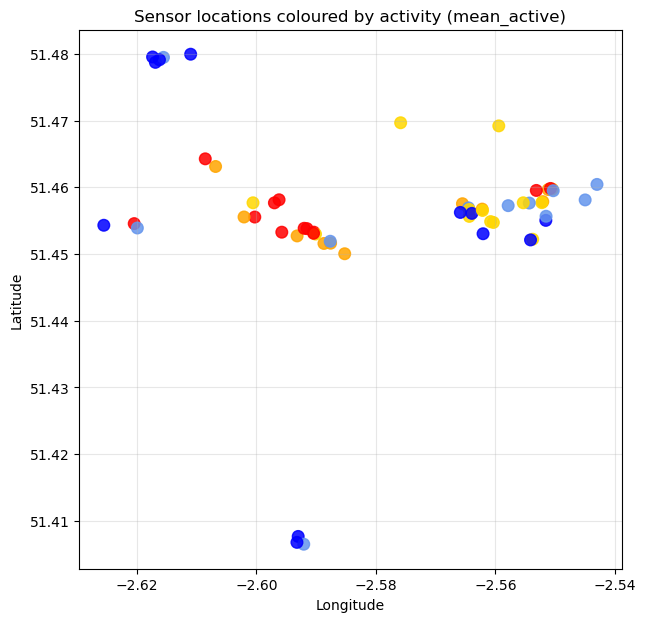

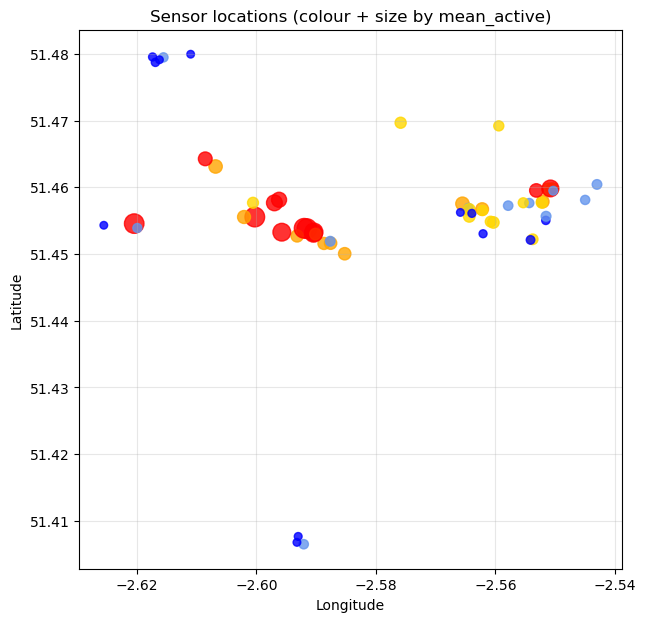


                            RESULTS: GRID-BASED CLUSTERING                           
Grid size (degrees): 0.003
Number of clusters: 34
Top 10 cluster sizes (# sensors in cluster):
cluster_id
22    5
31    4
16    3
2     3
17    3
12    3
21    2
11    2
30    2
23    2



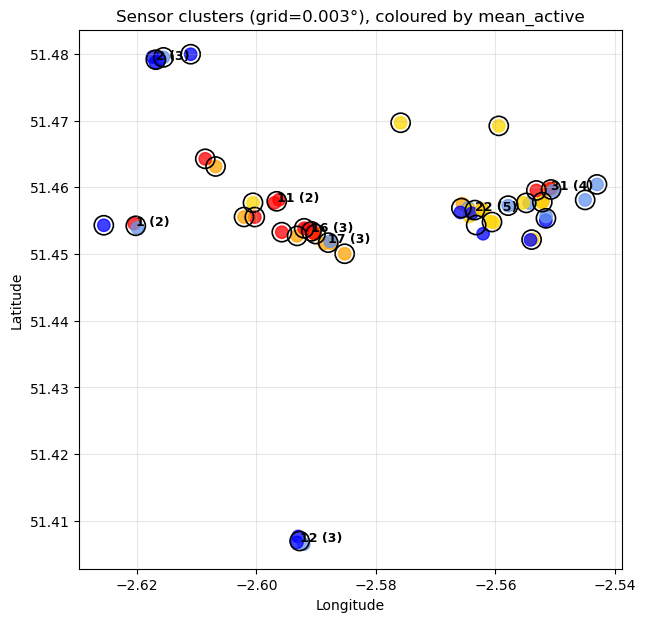

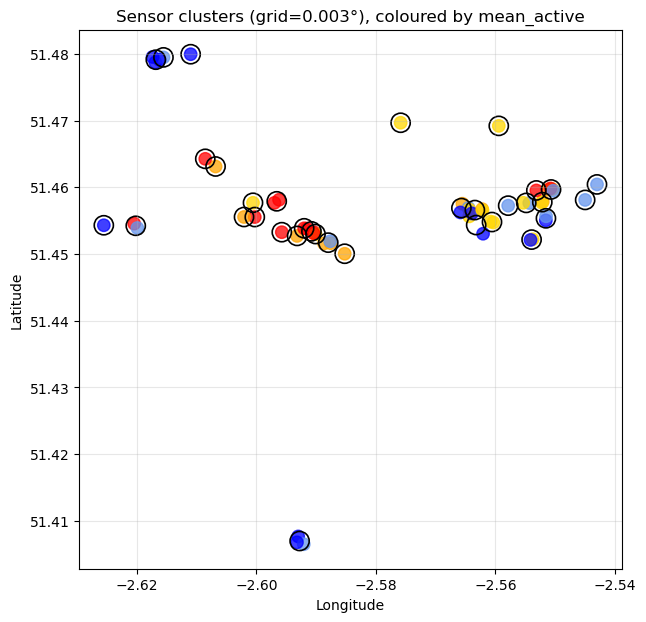

Saved PNG: ../figures/sensor_activity_clusters.png
Saved Google My Maps CSV: ../figures/sensors_for_google_maps.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# -----------------------------
# Settings 
# -----------------------------
SENS_PATH = "../data/mdm2_data_files/Sensor_Location.csv"
BIG_PATH  = "../data/mdm2_data_files/big_table.csv"

# Choose how to define "activity" for colouring:
#   "mean_active" = fair comparison (recommended)
#   "sum_active"  = total volume story
COLOR_METRIC = "mean_active"

# Grid clustering size (degrees). Smaller -> more clusters.
GRID_DEG = 0.003

# Output files
OUT_DIR = "../figures"
OUT_PNG = os.path.join(OUT_DIR, "sensor_activity_clusters.png")
OUT_CSV = os.path.join(OUT_DIR, "sensors_for_google_maps.csv")


# -----------------------------
# 1) Load data
# -----------------------------
sens = pd.read_csv(SENS_PATH)
big  = pd.read_csv(BIG_PATH)

# Standardise Sensor_Location columns to match big_table naming
sens = sens.rename(columns={
    "SensorNumber": "sensor_id",
    "Longitude": "longitude",
    "Latitude": "latitude"
})

# Ensure the key matches in both tables
sens["sensor_id"] = pd.to_numeric(sens["sensor_id"], errors="coerce").astype("Int64")
big["sensor_id"]  = pd.to_numeric(big["sensor_id"], errors="coerce").astype("Int64")

sens = sens.dropna(subset=["sensor_id", "latitude", "longitude"]).copy()
big  = big.dropna(subset=["sensor_id"]).copy()

# Ensure counts are numeric
for col in ["ped", "cyc", "car", "active"]:
    if col in big.columns:
        big[col] = pd.to_numeric(big[col], errors="coerce")

# If 'active' not present or too many NaNs, define it
if ("active" not in big.columns) or (big["active"].isna().mean() > 0.5):
    if ("ped" in big.columns) and ("cyc" in big.columns):
        big["active"] = big["ped"].fillna(0) + big["cyc"].fillna(0)
    else:
        raise ValueError("big_table.csv must contain either 'active' or both 'ped' and 'cyc' columns.")

print("\nLoaded:")
print("  Sensors (location file):", len(sens))
print("  Rows (big table):", len(big))


# -----------------------------
# 2) Activity per sensor + merge
# -----------------------------
activity = (big.groupby("sensor_id")["active"]
            .agg(mean_active="mean", sum_active="sum", n="count")
            .reset_index())

df = sens.merge(activity, on="sensor_id", how="left")

# Fill missing activity with 0 (in case any sensor location has no data)
for col in ["mean_active", "sum_active", "n"]:
    df[col] = df[col].fillna(0)

df_plot = df.dropna(subset=["latitude", "longitude"]).copy()

print("\nMerged table:")
print("  Rows:", len(df_plot))
print("  Example:\n", df_plot[["sensor_id","latitude","longitude","mean_active","sum_active","n"]].head())


# -----------------------------
# 3) Create colour buckets (blue -> red)
# -----------------------------
vals = df_plot[COLOR_METRIC].to_numpy()

# Handle constant edge case (all zeros etc.)
if np.all(vals == vals[0]):
    qs = np.array([vals[0]]*6)
else:
    qs = np.quantile(vals, [0, 0.2, 0.4, 0.6, 0.8, 1.0])

def activity_level(x):
    if x <= qs[1]: return "Very Low"
    if x <= qs[2]: return "Low"
    if x <= qs[3]: return "Medium"
    if x <= qs[4]: return "High"
    return "Very High"

color_map = {
    "Very Low": "blue",
    "Low": "cornflowerblue",
    "Medium": "gold",
    "High": "orange",
    "Very High": "red"
}

df_plot["activity_level"] = df_plot[COLOR_METRIC].apply(activity_level)
df_plot["color"] = df_plot["activity_level"].map(color_map)

print("\nActivity bucket counts:")
print(df_plot["activity_level"].value_counts().to_string())


# -----------------------------
# 4) Plot 1: simple coloured sensor map (lon/lat)
# -----------------------------
plt.figure(figsize=(7,7))
plt.scatter(df_plot["longitude"], df_plot["latitude"], c=df_plot["color"], s=70, alpha=0.85)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Sensor locations coloured by activity ({COLOR_METRIC})")
plt.grid(True, alpha=0.3)
plt.show()


# -----------------------------
# 5) Plot 2: size + colour by activity
# -----------------------------
v = df_plot[COLOR_METRIC].to_numpy()
vmin, vmax = np.percentile(v, 5), np.percentile(v, 95)
vclip = np.clip(v, vmin, vmax)
sizes = 30 + 170*(vclip - vmin)/(vmax - vmin + 1e-9)

plt.figure(figsize=(7,7))
plt.scatter(df_plot["longitude"], df_plot["latitude"], c=df_plot["color"], s=sizes, alpha=0.8)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Sensor locations (colour + size by {COLOR_METRIC})")
plt.grid(True, alpha=0.3)
plt.show()


# -----------------------------
# 6) Grid-based clustering (no extra libraries)
# -----------------------------
df_plot["cell_x"] = np.floor(df_plot["longitude"] / GRID_DEG).astype(int)
df_plot["cell_y"] = np.floor(df_plot["latitude"] / GRID_DEG).astype(int)
df_plot["cluster_id"] = df_plot.groupby(["cell_x","cell_y"]).ngroup()

cluster_sizes = df_plot["cluster_id"].value_counts().sort_values(ascending=False)

centers = (df_plot.groupby("cluster_id")[["longitude","latitude"]]
           .mean()
           .rename(columns={"longitude":"clon","latitude":"clat"}))
centers["count"] = df_plot["cluster_id"].value_counts()

print("\n" + "="*85)
print("RESULTS: GRID-BASED CLUSTERING".center(85))
print("="*85)
print(f"Grid size (degrees): {GRID_DEG}")
print(f"Number of clusters: {df_plot['cluster_id'].nunique()}")
print("Top 10 cluster sizes (# sensors in cluster):")
print(cluster_sizes.head(10).to_string())
print("="*85 + "\n")


# Plot clusters: centers + labels for top clusters
plt.figure(figsize=(7,7))
plt.scatter(df_plot["longitude"], df_plot["latitude"], c=df_plot["color"], s=80, alpha=0.75)
plt.scatter(centers["clon"], centers["clat"], s=190, facecolors="none", edgecolors="black", linewidths=1.2)

topk = 8
top_ids = centers.sort_values("count", ascending=False).head(topk).index.tolist()
for cid in top_ids:
    x = centers.loc[cid, "clon"]
    y = centers.loc[cid, "clat"]
    c = int(centers.loc[cid, "count"])
    plt.text(x, y, f"{cid} ({c})", fontsize=9, weight="bold")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Sensor clusters (grid={GRID_DEG}°), coloured by {COLOR_METRIC}")
plt.grid(True, alpha=0.3)
plt.show()


# -----------------------------
# 7) Save outputs (PNG + Google My Maps CSV)
# -----------------------------
os.makedirs(OUT_DIR, exist_ok=True)

# Save PNG
plt.figure(figsize=(7,7))
plt.scatter(df_plot["longitude"], df_plot["latitude"], c=df_plot["color"], s=80, alpha=0.75)
plt.scatter(centers["clon"], centers["clat"], s=190, facecolors="none", edgecolors="black", linewidths=1.2)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Sensor clusters (grid={GRID_DEG}°), coloured by {COLOR_METRIC}")
plt.grid(True, alpha=0.3)
plt.savefig(OUT_PNG, dpi=200, bbox_inches="tight")
plt.show()

# Export CSV for Google My Maps (style by activity_level)
export = df_plot[["sensor_id","latitude","longitude","mean_active","sum_active","n","cluster_id","activity_level"]].copy()
export.to_csv(OUT_CSV, index=False)

print("Saved PNG:", OUT_PNG)
print("Saved Google My Maps CSV:", OUT_CSV)